In [1]:
# Imports 
import os
import pdb
import numpy as np
import openmdao.api as om
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

os.environ["pyna_language"] = 'python'
from pyNA.pyna import pyna

In [2]:
# Inputs 
z_cb_lst = np.hstack((np.linspace(25, 250, 10), np.linspace(300, 750, 10)))

TS_cb_lst = dict()
TS_cb_lst['stca']= dict()
TS_cb_lst['stca']['V2'] = np.linspace(0.75, 1.0, 11)
TS_cb_lst['stca']['Vmax'] = np.linspace(0.4, 1.0, 25)
TS_cb_lst['a10'] = dict()
TS_cb_lst['a10']['V2'] = np.linspace(0.775, 1.0, 10)
TS_cb_lst['a10']['Vmax'] = np.linspace(0.675, 1.0, 14)

Vmax_lst = dict()
Vmax_lst['stca'] = dict()
Vmax_lst['stca']['V2'] = 197*0.51444444
Vmax_lst['stca']['Vmax'] = 250*0.51444444
Vmax_lst['a10'] = dict()
Vmax_lst['a10']['V2'] = 234.4*0.51444444
Vmax_lst['a10']['Vmax'] = 250*0.51444444


In [4]:
# Get groundroll distance for trajectories 
if False:
    x_to = dict()

    for kk, ac_name in enumerate(['stca', 'a10']):

        x_to[ac_name] = dict()

        for ll, case in enumerate(['V2', 'Vmax']):

            x_to[ac_name][case] = np.zeros((np.size(z_cb_lst), np.size(TS_cb_lst[ac_name][case])))

            for j,TS in enumerate(TS_cb_lst[ac_name][case]):
                for i, z_cb in enumerate(z_cb_lst):
                    t = pd.read_csv('../cases/'+ac_name+'/trajectory/STCB/'+case+'/trajectory_' + ac_name + '_' + str(np.round(z_cb, 3)) + '_' + str(np.round(TS, 3)) + '.csv')

                    idx = np.where(t['Z [m]']>0)[0][0]

                    x_to[ac_name][case][i,j] = t['X [m]'][idx]

            print(ac_name, '; ', case, '; ', np.mean(x_to[ac_name][case])) 

In [22]:
def plot_stcb_design_sweep(ac_name, z_cb_lst, TS_cb_lst, epnl_lateral, epnl_flyover, epnl_lateral_pr, epnl_flyover_pr): 

    fig, ax = plt.subplots(1,3,figsize=(20,4), sharey=True, dpi=100)
    plt.style.use('../utils/plot.mplstyle')
    fontsize=16
    
    # Get linspace for levels
    if ac_name == 'stca':
        lev_min = 83
        lev_max = 99
        delta_tick = 2
        lev_min_to = 177
        lev_max_to = 191
    elif ac_name == 'a10':
        lev_min = 94
        lev_max = 104
        delta_tick = 1
        lev_min_to = 196
        lev_max_to = 204
    
    levels=np.arange(lev_min, lev_max+0.1, 0.5)
    ax[0].contour(TS_cb_lst, z_cb_lst, np.round(epnl_lateral, 2), levels=levels, colors='k', linewidths=0.5, alpha=0.5)
    C0 = ax[0].contourf(TS_cb_lst, z_cb_lst, epnl_lateral, cmap='magma', levels=levels)
    cbar0 = plt.colorbar(C0, ax=ax[0])
    cbar0.set_ticks(np.arange(lev_min, lev_max+0.1, delta_tick))
    cbar0.ax.tick_params()
    ax[0].set_title(r'$EPNL_{lateral}$ [EPNdB]', pad=10)
    ax[0].set_ylabel('$z_{cb}\ [m]$')
    i_base = np.unravel_index(np.argmin(epnl_lateral, axis=None), epnl_lateral.shape)
    ax[0].plot([TS_cb_lst[i_base[1]]], [z_cb_lst[i_base[0]]], '*', markerfacecolor='w', markeredgecolor='grey', markersize=20)

    ax[1].contour(TS_cb_lst, z_cb_lst, epnl_flyover, levels=levels, colors='k', linewidths=0.5, alpha=0.5)
    C1 = ax[1].contourf(TS_cb_lst, z_cb_lst, epnl_flyover, levels=levels, cmap='magma')
    cbar1 = plt.colorbar(C1, ax=ax[1])
    cbar1.ax.tick_params()
    cbar1.set_ticks(np.arange(lev_min, lev_max+0.1, delta_tick))
    ax[1].set_title(r'$EPNL_{flyover}$ [EPNdB]', pad=10)
    i_base = np.unravel_index(np.argmin(epnl_flyover, axis=None), epnl_flyover.shape)
    ax[1].plot([TS_cb_lst[i_base[1]]], [z_cb_lst[i_base[0]]], '*', markerfacecolor='w', markeredgecolor='grey', markersize=20)
    
    epnl_total = epnl_lateral + epnl_flyover
    epnl_total_pr = epnl_lateral_pr + epnl_flyover_pr
    lev_min = np.floor(np.min((np.min(epnl_total), np.min(epnl_total_pr))))
    lev_max = np.ceil(np.max((np.max(epnl_total), np.max(epnl_total_pr))))

    levels=np.arange(lev_min_to, lev_max_to+0.1, 0.5)
    ax[2].contour(TS_cb_lst, z_cb_lst, epnl_total, levels=levels, colors='k', linewidths=0.5, alpha=0.5)
    C2 = ax[2].contourf(TS_cb_lst, z_cb_lst, epnl_total, levels=levels, cmap='magma')
    cbar2 = plt.colorbar(C2, ax=ax[2])
    cbar2.ax.tick_params()
    cbar2.set_ticks(np.arange(lev_min_to, lev_max_to+0.1, delta_tick))
    ax[2].set_title(r'$EPNL_{take-off}$ [EPNdB]', pad=10)
    i_base1 = np.unravel_index(np.argmin(epnl_flyover, axis=None), epnl_total.shape)
    i_base2 = np.unravel_index(np.argmin(epnl_total[:10,:], axis=None), epnl_total.shape)
    ax[2].plot([TS_cb_lst[i_base1[1]]], [z_cb_lst[i_base1[0]]], '*', markerfacecolor='w', markeredgecolor='grey', markersize=20)
    ax[2].plot([TS_cb_lst[i_base2[1]]], [z_cb_lst[i_base2[0]]], '*', markerfacecolor='w', markeredgecolor='grey', markersize=20)
    
    for i in np.arange(3):
        ax[i].set_xlim([0.30, 1.0])
        ax[i].set_xlabel('$TS_{cb}\ [-]$')
        ax[i].tick_params(axis='both')
        ax[i].set_xticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        ax[i].set_yticks([25, 250, 500, 750])
        ax[i].fill_between([0.30, TS_cb_lst[0]], [25,25], [750,750], facecolor='w', hatch='/')

        
        if ac_name == 'stca':
            ax[i].plot([0.3, 1.0], [260, 260], 'k--', linewidth=1.5) 
            ax[i].annotate(r"$z_{cb} > 260 m \uparrow$", xy=(0.33, 295), fontsize=fontsize, color='k', bbox=dict(facecolor='w', edgecolor='w', alpha=0.9))
            # ax[i].annotate("", xy=(0.4, 345), xycoords='data', xytext=(0.96, 255), textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='k'), color='k')

        elif ac_name == 'a10':
            ax[i].plot([0.3, 1.0], [210, 210], 'k--', linewidth=1.5) 
            ax[i].annotate(r"$z_{cb} > 210 m \uparrow$", xy=(0.33, 245), fontsize=fontsize, color='k', bbox=dict(facecolor='w', edgecolor='w', alpha=0.9))
            # ax[i].annotate("", xy=(0.4, 395), xycoords='data', xytext=(0.96, 205), textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='k'), color='k')
        
    plt.subplots_adjust(wspace=0.05) 
    
    # Print lateral noise constraints
    i_lat = np.unravel_index(np.argmin(epnl_lateral, axis=None), epnl_lateral.shape)  
        
    print("EPNL constraint: ", epnl_lateral[i_lat])

In [23]:
# Load 
epnl_sideline = dict()
epnl_lateral = dict()
epnl_flyover = dict()

lat_att = False

for ac_name in ['stca', 'a10']:
    
    epnl_sideline[ac_name] = dict()
    epnl_lateral[ac_name] = dict()
    epnl_flyover[ac_name] = dict()
    
    for case in ['V2', 'Vmax']:
    
        if ac_name == 'stca' and case == 'V2':
            start = 20
        elif ac_name == 'stca' and case == 'Vmax':
            start = 35
        elif ac_name == 'a10' and case == 'V2':
            start = 60
        elif ac_name == 'a10' and case == 'Vmax':
            start = 70

        if ac_name == 'stca':
            epnl_flyover[ac_name][case] = np.load('../cases/'+ac_name+'/output/STCB/'+case+'/sweeps_lat/epnl_flyover.npy') 
            epnl_sideline[ac_name][case] = np.load('../cases/'+ac_name+'/output/STCB/'+case+'/sweeps_lat/epnl_sideline.npy') 
        elif ac_name == 'a10':
            epnl_flyover[ac_name][case] = np.load('../cases/'+ac_name+'/output/STCB/'+case+'/sweeps/epnl_flyover.npy') 
            epnl_sideline[ac_name][case] = np.load('../cases/'+ac_name+'/output/STCB/'+case+'/sweeps/epnl_sideline.npy') 
            
        epnl_lateral[ac_name][case] = np.max(epnl_sideline[ac_name][case][:,:,start:], axis=2)


### NASA STCA

EPNL constraint:  93.21453641852032
EPNL constraint:  86.89487006753819


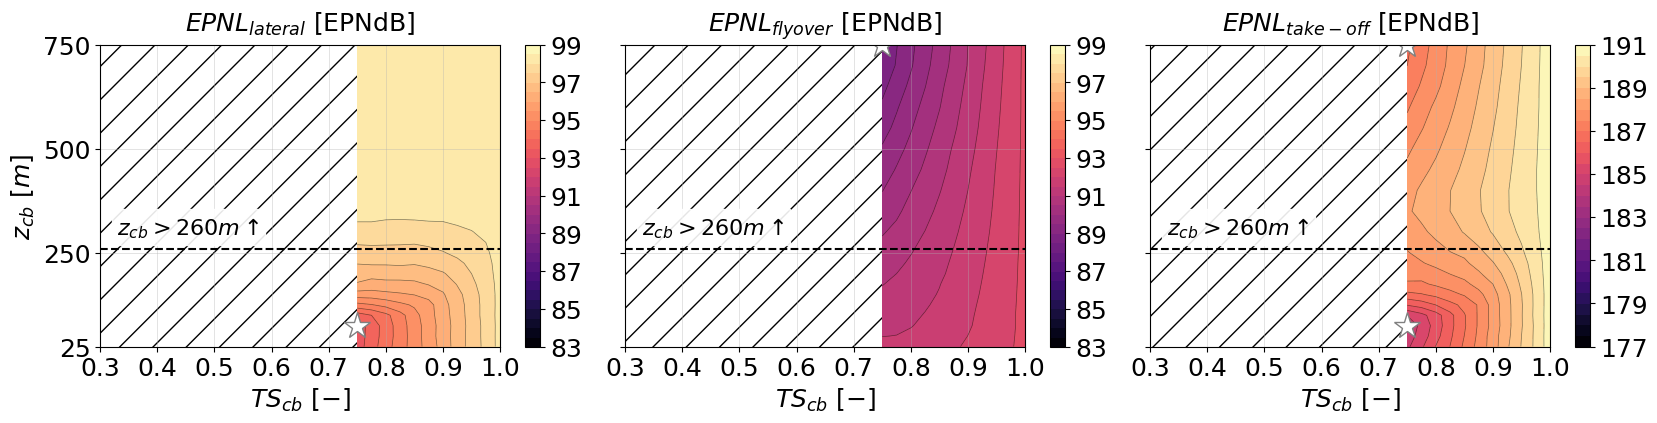

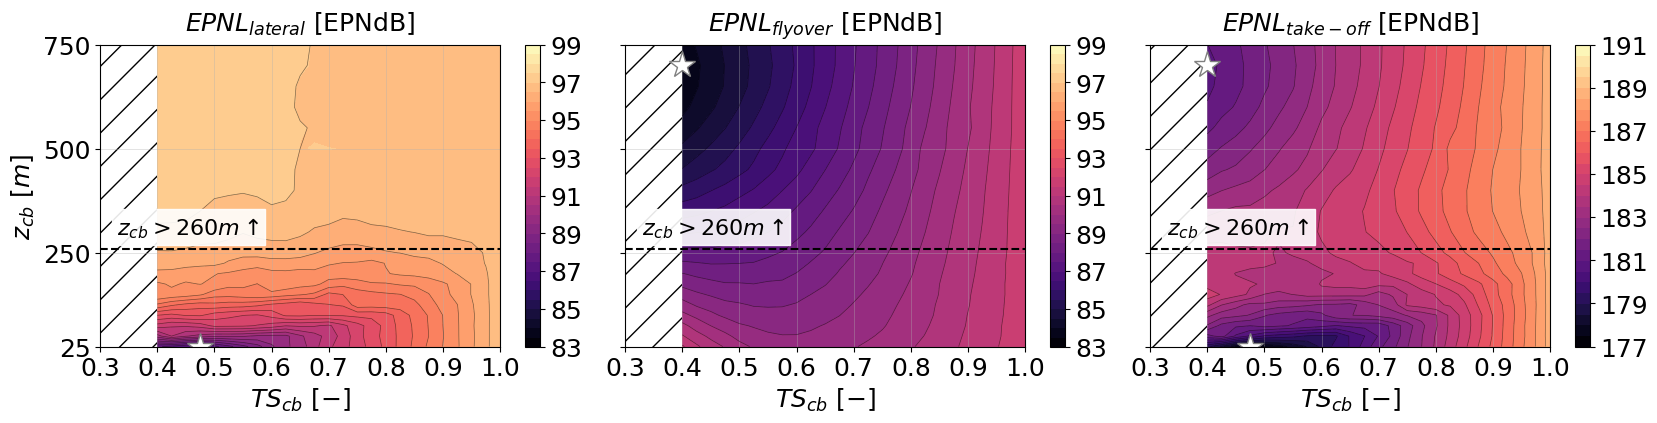

In [24]:
plot_stcb_design_sweep('stca', z_cb_lst, TS_cb_lst['stca']['V2'], epnl_lateral['stca']['V2'], epnl_flyover['stca']['V2'], epnl_lateral['stca']['Vmax'], epnl_flyover['stca']['Vmax'])
plot_stcb_design_sweep('stca', z_cb_lst, TS_cb_lst['stca']['Vmax'], epnl_lateral['stca']['Vmax'], epnl_flyover['stca']['Vmax'], epnl_lateral['stca']['V2'], epnl_flyover['stca']['V2'])

### GT Medium SST

In [29]:
if False:
    plot_stcb_design_sweep('a10', z_cb_lst, TS_cb_lst['a10']['V2'], epnl_lateral['a10']['V2'], epnl_flyover['a10']['V2'], epnl_lateral['a10']['Vmax'], epnl_flyover['a10']['Vmax'])
    plot_stcb_design_sweep('a10', z_cb_lst, TS_cb_lst['a10']['Vmax'], epnl_lateral['a10']['Vmax'], epnl_flyover['a10']['Vmax'], epnl_lateral['a10']['V2'], epnl_flyover['a10']['V2'])

### Plot sideline noise

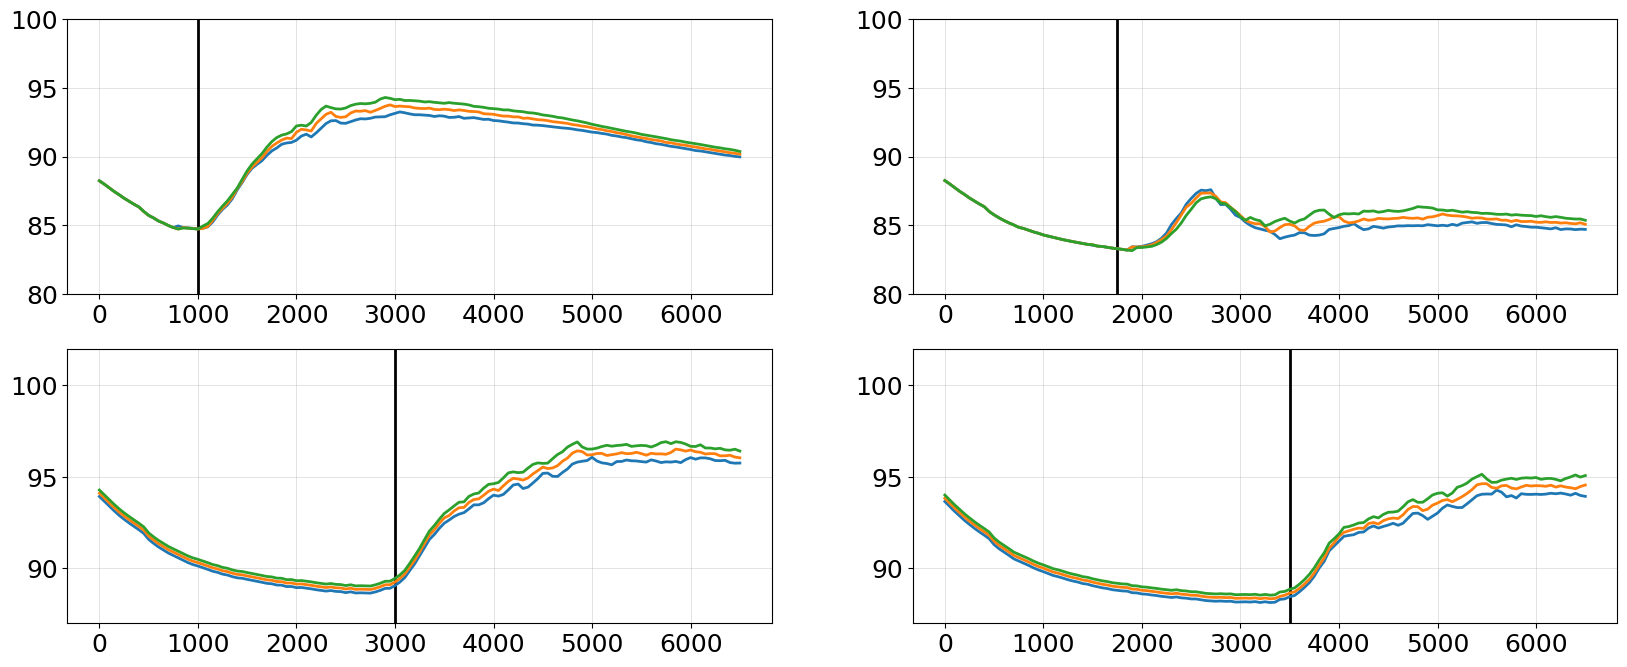

In [31]:
fig, ax = plt.subplots(2,2, figsize=(20, 8))

x_lst = np.linspace(0, 6500, 131)

for rr, ac_name in enumerate(['stca', 'a10']):
    for cc, case in enumerate(['V2', 'Vmax']):

        if ac_name == 'stca' and case == 'V2':
            start = 20
            ax[rr,cc].plot([x_lst[start], x_lst[start]], [80, 100], 'k')
            ax[rr,cc].set_ylim([80, 100])
        elif ac_name == 'stca' and case == 'Vmax':
            start = 35
            ax[rr,cc].plot([x_lst[start], x_lst[start]], [80, 100], 'k')
            ax[rr,cc].set_ylim([80, 100])
        elif ac_name == 'a10' and case == 'V2':
            start = 60
            ax[rr,cc].plot([x_lst[start], x_lst[start]], [87, 102], 'k')
            ax[rr,cc].set_ylim([87, 102])
        elif ac_name == 'a10' and case == 'Vmax':
            start = 70
            ax[rr,cc].plot([x_lst[start], x_lst[start]], [87, 102], 'k')
            ax[rr,cc].set_ylim([87, 102])
        
        for j,TS in enumerate(TS_cb_lst[ac_name][case][:3]):
            for i, z_cb in enumerate(z_cb_lst[0]): 
                ax[rr, cc].plot(x_lst, epnl_sideline[ac_name][case][i,j,:])
                

In [59]:
M = 78.7

In [69]:
lat_77 = 91.83 +  6.64*np.log10(M)
app_77 = 91.83 +  6.64*np.log10(M)
fly_77 = 67.56 + 16.61*np.log10(M)

lat_17 = 80.86511 + 8.50668*np.log10(M)
app_17 = 86.03167 + 7.75117*np.log10(M)
fly_17 = 71.64514 + 13.28771*np.log10(M)


In [72]:
cum_77 = lat_77 + app_77 + fly_77

cum_17 = lat_17 + app_17 + fly_17 - 17

print(cum_77)
print(cum_17)

print(348.4 - cum_77)
print(348.4 - cum_17)

307.8906847502124
277.5595552133987
40.50931524978756
70.84044478660127
